In [86]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.getcwd()
%matplotlib inline

In [7]:
os.chdir('/home/qc/modelling_projects/data/nyse')

In [8]:
os.listdir()

['prices.csv',
 'securities.csv',
 'fundamentals.csv',
 'prices-split-adjusted.csv']

In [77]:
prices = pd.read_csv('prices.csv')

prices = prices[prices['symbol'].isin(['EBAY', 'NVDA', 'YHOO'])]

prices = prices[['date', 'symbol', 'close']]

prices = prices.pivot('date', 'symbol')

prices = prices['close']

prices = prices.reset_index()
prices.index = prices['date']

prices.index = pd.to_datetime(prices.index)
prices = prices.drop('date', axis = 1)
# manually truncate data
prices.loc['2013-01-02':'2014-01-31', 'EBAY'] = np.nan
prices.loc['2011-01-03':'2012-12-31', 'NVDA'] = np.nan
prices.loc['2011-05-02':'2012-03-30', 'YHOO'] = np.nan

In [79]:
prices.head()

symbol,EBAY,NVDA,YHOO
date,,,
2010-01-04,23.900000,18.490000,17.100000
2010-01-05,23.650000,18.760000,17.230000
2010-01-06,23.500000,18.879999,17.170000
2010-01-07,23.229998,18.510000,16.700001
2010-01-08,23.509999,18.549999,16.700001


## Visualizing messy data
Let's take a look at a new dataset - this one is a bit less-clean than what you've seen before.

As always, you'll first start by visualizing the raw data. Take a close look and try to find datapoints that could be problematic for fitting models.

The data has been loaded into a DataFrame called prices.

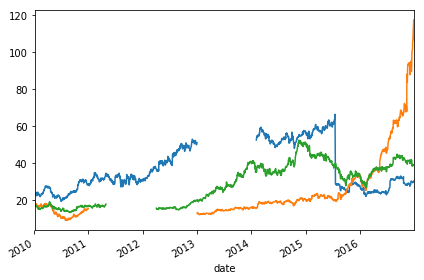

symbol
EBAY    273
NVDA    502
YHOO    232
dtype: int64


In [80]:
# Visualize the dataset
prices.plot(legend=False)
plt.tight_layout()
plt.show()

# Count the missing values of each time series
missing_values = prices.isna().sum()
print(missing_values)

## Imputing missing values
When you have missing data points, how can you fill them in?

In this exercise, you'll practice using different interpolation methods to fill in some missing values, visualizing the result each time. But first, you will create the function (interpolate_and_plot()) you'll use to interpolate missing data points and plot them.

A single time series has been loaded into a DataFrame called prices.

In [70]:
# Create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):

    # Create a boolean mask for missing values
    missing_values = prices.isna()

    # Interpolate the missing values
    prices_interp = prices.interpolate(interpolation)

    # Plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)
    plt.show()

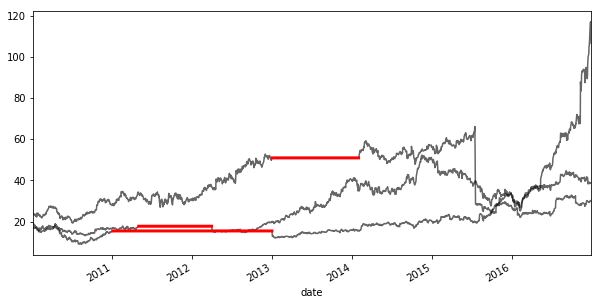

In [81]:
interpolation_type = 'zero'
interpolate_and_plot(prices, interpolation_type)

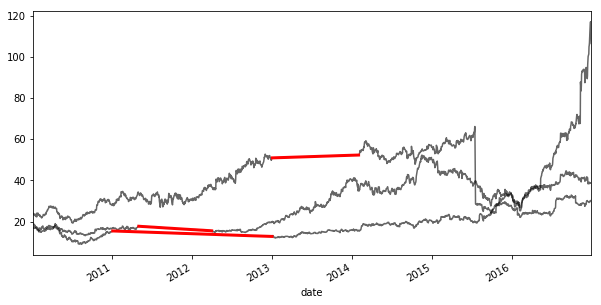

In [82]:
# Interpolate linearly
interpolation_type = 'linear'
interpolate_and_plot(prices, interpolation_type)

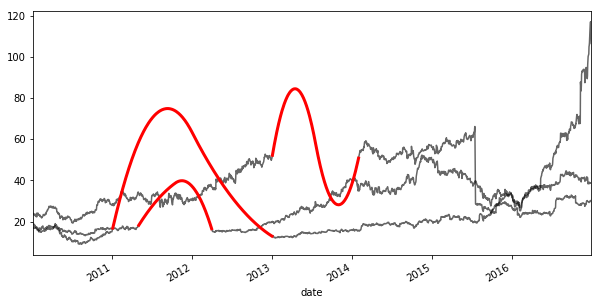

In [83]:
# Interpolate with a quadratic function
interpolation_type = 'quadratic'
interpolate_and_plot(prices, interpolation_type)

Correct! When you interpolate, the pre-existing data is used to infer the values of missing data. As you can see, the method you use for this has a big effect on the outcome.

## Transforming raw data
In the last chapter, you calculated the rolling mean. In this exercise, you will define a function that calculates the percent change of the latest data point from the mean of a window of previous data points. This function will help you calculate the percent change over a rolling window.

This is a more stable kind of time series that is often useful in machine learning.

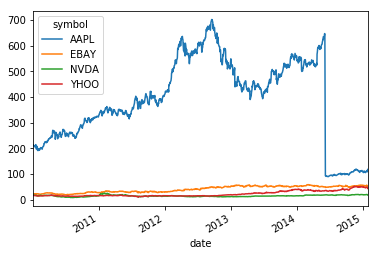

In [384]:
# prepare the data
prices = pd.read_csv('prices.csv')
prices = prices[prices['symbol'].isin(['EBAY', 'NVDA', 'YHOO', 'AAPL'])]
prices = prices[['date', 'symbol', 'close']]
prices = prices.pivot('date', 'symbol')
prices = prices['close']
prices = prices.reset_index()
prices.index = prices['date']
prices.index = pd.to_datetime(prices.index)
prices = prices.drop('date', axis = 1)
prices = prices.loc[:"2015-01-30", :]
prices.plot()

/home/qc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if sys.path[0] == '':


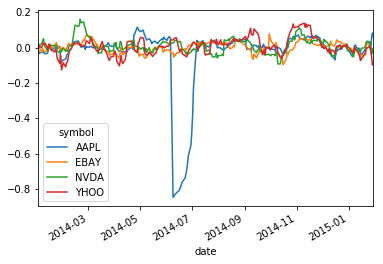

In [385]:
# Your custom function
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

# Apply your custom function and plot
prices_perc = prices.rolling(20).apply(percent_change)
prices_perc.loc["2014":"2015"].plot()
plt.show()

## Handling outliers
In this exercise, you'll handle outliers - data points that are so different from the rest of your data, that you treat them differently from other "normal-looking" data points. You'll use the output from the previous exercise (percent change over time) to detect the outliers. First you will write a function that replaces outlier data points with the median value from the entire time series.

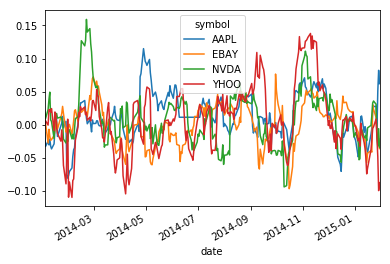

In [386]:
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series

# Apply your preprocessing function to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc["2014":"2015", :].plot()
plt.show()

# Engineering multiple rolling features at once
Now that you've practiced some simple feature engineering, let's move on to something more complex. You'll calculate a collection of features for your time series data and visualize what they look like over time. This process resembles how many other time series models operate.

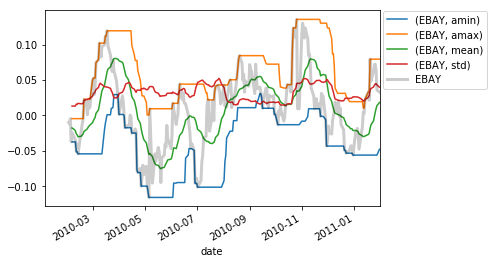

In [387]:
# Define a rolling window with Pandas, excluding the right-most datapoint of the window
prices_perc = prices_perc[['EBAY']]
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')

# Define the features you'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling.aggregate(features_to_calculate)

# Plot the results
ax = features.loc[:"2011-01"].plot()
prices_perc.loc[:"2011-01"].plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, .6))
plt.show()

## Percentiles and partial functions
In this exercise, you'll practice how to pre-choose arguments of a function so that you can pre-configure how it runs. You'll use this to calculate several percentiles of your data using the same percentile() function in numpy.

/home/qc/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


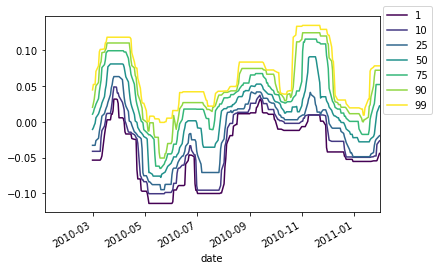

In [388]:
# Import partial from functools
from functools import partial
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')
features_percentiles = prices_perc_rolling.aggregate(percentile_functions)

# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"]['EBAY'].plot(cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5))
plt.show()

## Using "date" information
It's easy to think of timestamps as pure numbers, but don't forget they generally correspond to things that happen in the real world. That means there's often extra information encoded in the data such as "is it a weekday?" or "is it a holiday?". This information is often useful in predicting timeseries data.

In this exercise, you'll extract these date/time based features. A single time series has been loaded in a variable called prices.

In [392]:
prices_perc.index = pd.to_datetime(prices_perc.index)

# Extract date features from the data, add them as columns
prices_perc['day_of_week'] = prices_perc.index.dayofweek
prices_perc['week_of_year'] = prices_perc.index.weekofyear
prices_perc['month_of_year'] = prices_perc.index.month

# Print prices_perc
# print(prices_perc)
features_dates = prices_perc.iloc[:, 1:]
features_dates

symbol,day_of_week,week_of_year,month_of_year
date,,,
2010-01-04,0,1,1
2010-01-05,1,1,1
2010-01-06,2,1,1
2010-01-07,3,1,1
2010-01-08,4,1,1
2010-01-11,0,2,1
2010-01-12,1,2,1
2010-01-13,2,2,1
2010-01-14,3,2,1


# An AR predictive model

In [438]:
prices_perc = prices_perc['EBAY']

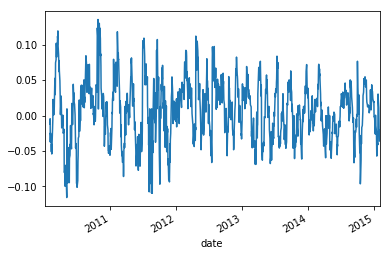

In [332]:
prices_perc.plot()

To capture the trend of the data, we can use rolling mean method.

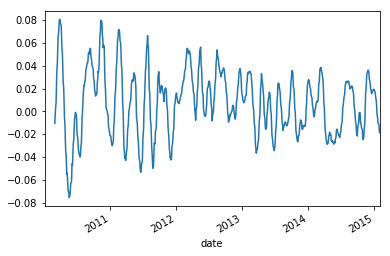

In [340]:
rolling_mean = prices_perc.rolling(20).mean()
rolling_mean.iloc[:].plot()

In [304]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [308]:
prices_perc_filled = prices_perc.fillna(np.nanmean(prices_perc))

In [313]:
prices_perc_filled = pd.DataFrame(prices_perc_filled)

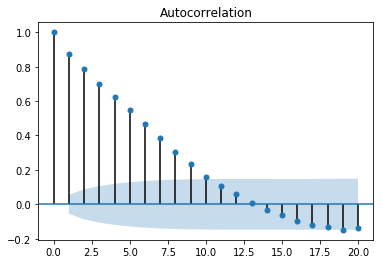

In [323]:
plot_acf(prices_perc_filled, alpha=.05, lags=20)
plt.show()

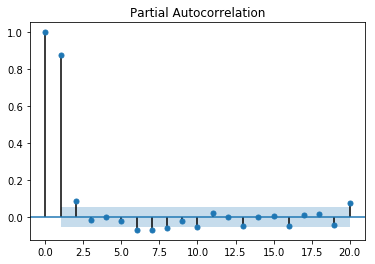

In [322]:
plot_pacf(prices_perc_filled, alpha=.05, lags=20)
plt.show()

In [341]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(prices_perc_filled.iloc[:,0])
result

(-8.989027765894223,
 6.9729990373067505e-15,
 9,
 1268,
 {'1%': -3.4355176558157616,
  '5%': -2.8638220694163588,
  '10%': -2.5679849962931267},
 -6199.231057925674)

Although ADF test suggests the data are not stationary, the stationarity feature is a time-varying feature. So we need to rely on our intuition to judge it soometimes. Note that most variables at levels should not be stationary. However in our case, what we use is already a rolling a percent-change variable, so we should have confidence that the variable is stationary.


## Creating time-shifted features
In machine learning for time series, it's common to use information about previous time points to predict a subsequent time point.

In this exercise, you'll "shift" your raw data and visualize the results. You'll use the percent change time series that you calculated in the previous chapter, this time with a very short window. A short window is important because, in a real-world scenario, you want to predict the day-to-day fluctuations of a time series, not its change over a longer window of time.

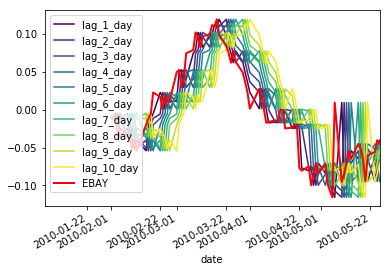

In [290]:
# These are the "time lags"
shifts = np.arange(1, 11)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis)
prices_perc.iloc[:100].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

## Special case: Auto-regressive models
Now that you've created time-shifted versions of a single time series, you can fit an auto-regressive model. This is a regression model where the input features are time-shifted versions of the output time series data. You are using previous values of a timeseries to predict current values of the same timeseries (thus, it is auto-regressive).

By investigating the coefficients of this model, you can explore any repetitive patterns that exist in a timeseries, and get an idea for how far in the past a data point is predictive of the future.

In [457]:
# Replace missing values with the median for each column
from sklearn.linear_model import Ridge

X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

## Visualize regression coefficients
Now that you've fit the model, let's visualize its coefficients. This is an important part of machine learning because it gives you an idea for how the different features of a model affect the outcome.

The shifted time series DataFrame (prices_perc_shifted) and the regression model (model) are available in your workspace.

In this exercise, you will create a function that, given a set of coefficients and feature names, visualizes the coefficient values.

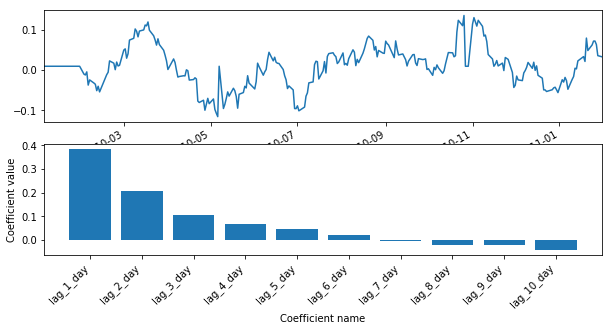

In [440]:
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
    
    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax

# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

In [442]:
names = ['percentile_{}'.format(i) for i in percentiles]
features_percentiles = features_percentiles['EBAY']
features_percentiles.columns = names

In [445]:
features_percentiles.head()

,percentile_1,percentile_10,percentile_25,percentile_50,percentile_75,percentile_90,percentile_99
date,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [405]:
features = features['EBAY']
features.head()

,amin,amax,mean,std
date,,,,
2010-01-04,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN


In [449]:
extend_X = pd.concat([features.fillna(np.nanmedian(features)), features_percentiles.fillna(np.nanmedian(features_percentiles)), features_dates],axis = 1)


In [450]:
extend_X

,amin,amax,mean,std,percentile_1,percentile_10,percentile_25,percentile_50,percentile_75,percentile_90,percentile_99,day_of_week,week_of_year,month_of_year
date,,,,,,,,,,,,,,
2010-01-04,0.019510,0.019510,0.019510,0.019510,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,0,1,1
2010-01-05,0.019510,0.019510,0.019510,0.019510,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,1,1,1
2010-01-06,0.019510,0.019510,0.019510,0.019510,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,2,1,1
2010-01-07,0.019510,0.019510,0.019510,0.019510,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,3,1,1
2010-01-08,0.019510,0.019510,0.019510,0.019510,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,4,1,1
2010-01-11,0.019510,0.019510,0.019510,0.019510,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,0,2,1
2010-01-12,0.019510,0.019510,0.019510,0.019510,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,1,2,1
2010-01-13,0.019510,0.019510,0.019510,0.019510,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,2,2,1
2010-01-14,0.019510,0.019510,0.019510,0.019510,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,0.010193,3,2,1


In [451]:
X = pd.concat([X, extend_X], axis = 1)

In [453]:
model.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

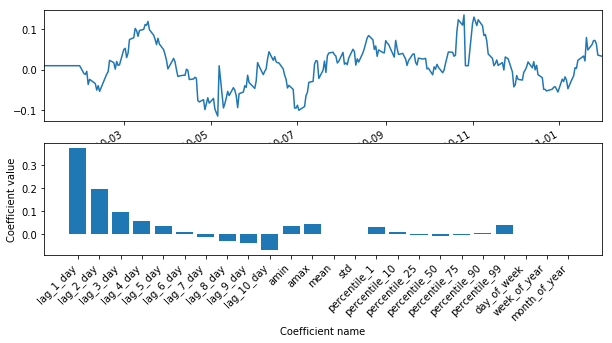

In [454]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, X.columns, ax=axs[1])
plt.show()

## Auto-regression with a smoother time series
Now, let's re-run the same procedure using a smoother signal. You'll use the same percent change algorithm as before, but this time use a much larger window (40 instead of 20). As the window grows, the difference between neighboring timepoints gets smaller, resulting in a smoother signal. What do you think this will do to the auto-regressive model?

prices_perc_shifted and model (updated to use a window of 40) are available in your workspace.

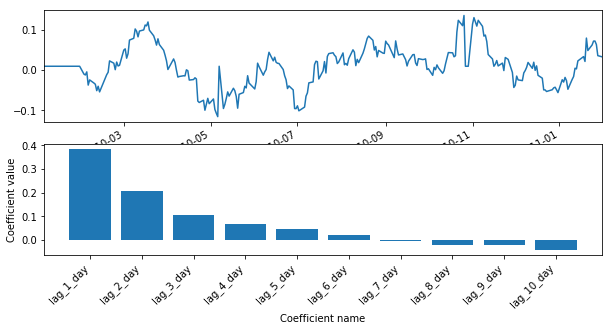

In [459]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))


# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

 As you can see here, by transforming your data with a larger window, you've also changed the relationship between each timepoint and the ones that come just before it. This model's coefficients gradually go down to zero, which means that the signal itself is smoother over time. Be careful when you see something like this, as it means your data is not i.i.d.

## Cross-validation with shuffling
As you'll recall, cross-validation is the process of splitting your data into training and test sets multiple times. Each time you do this, you choose a different training and test set. In this exercise, you'll perform a traditional ShuffleSplit cross-validation on the company value data from earlier. Later we'll cover what changes need to be made for time series data. The data we'll use is the same historical price data for several large companies.

An instance of the Linear regression object (model) is available in your workspace along with the function r2_score() for scoring. Also, the data is stored in arrays X and y. We've also provided a helper function (visualize_predictions()) to help visualize the results.

In [469]:
for tr, tt in cv.split(X, y):
    print(tr)
    print(tt)

[ 479  370  303 ... 1096  235 1061]
[ 133  655  395  248  969   60  863  881 1213  459  236  325  582 1218
  231  453  936  573   75 1068  797  700 1233  868 1178  692  991  629
 1153   81  259  950 1216 1029  255 1101 1011  736  177  301  195  216
  780 1084  675 1214  341  908  135  131  604  258  932  201  422   65
 1121  268  428 1126  163 1225  956  686 1182  694   88  408  107  529
  409  577 1103  108  576  674  820  401 1027  280  757  493  181 1091
  904  790 1186  119 1097 1241 1048  309  972  336   12  375  892  647
  708  909  190  350  725  920   49  581  982  636  111 1136  556  995
 1181  142  783  650 1113  283  958  671 1066  926  473 1060 1261 1230
 1062  404]
[ 902  496  796 ... 1172  599  284]
[1128  271 1074  990 1276  600  292  620  170  601  228  147  307  745
 1227  203  483 1045  187  785  956  875  850 1210  311 1048  397  318
  992  306  693  609  563  342    6  694 1145  321    4  477  177  755
  687  379 1182  195 1150  317 1094   79 1025  521  574   74  58

In [482]:
from sklearn.model_selection import cross_val_score

In [490]:
# Import ShuffleSplit and create the cross-validation object
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
cv = ShuffleSplit(10, random_state=1)

# Iterate through CV splits
results = []
X = np.array(X)
y = np.array(y)
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data, score the predictions, and collect
    prediction = model.predict(X[tt])
    score = r2_score(y[tt], prediction)
    results.append((prediction, score, tt))
    cv_score = cross_val_score(model, X, y, cv = cv)
cv_score
# Custom function to quickly visualize predictions
# visualize_predictions(results)

array([0.74808777, 0.7451516 , 0.71557875, 0.75645535, 0.67099126,
       0.71157433, 0.61460708, 0.6764501 , 0.71405242, 0.73790105])

In [491]:
# Create KFold cross-validation object
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=False, random_state=1)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data and collect
    prediction = model.predict(X[tt])
    results.append((prediction, tt))
    cv_score = cross_val_score(model, X, y, cv = cv)
cv_score

array([0.79117736, 0.62971327, 0.77178925, 0.52779973, 0.64896165,
       0.52542816, 0.71500581, 0.69542309, 0.77081356, 0.67736499])

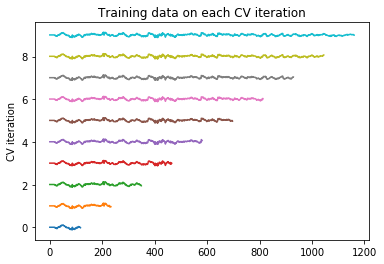

In [494]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(10)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + y[tr])

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

## Bootstrapping a confidence interval
A useful tool for assessing the variability of some data is the bootstrap. In this exercise, you'll write your own bootstrapping function that can be used to return a bootstrapped confidence interval.

This function takes three parameters: a 2-D array of numbers (data), a list of percentiles to calculate (percentiles), and the number of boostrap iterations to use (n_boots). It uses the resample function to generate a bootstrap sample, and then repeats this many times to calculate the confidence interval.

In [595]:
from sklearn.utils import resample

def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 2-D dataset."""
    # Create our empty array to fill the results
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)
        
    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

In [628]:
def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
     """Bootstrap a confidence interval for the mean of columns of a 1- or 2-D dataset."""
     # Create our empty array we'll fille with the results
     if data.ndim == 1:
         data = data[:, np.newaxis]
#      data = np.atleast_2d(data)
     bootstrap_means = np.zeros([n_boots, data.shape[-1]])
     for ii in range(n_boots):
         # Generate random indices for our data *with* replacement, then take the sample mean
         random_sample = resample(data)
         bootstrap_means[ii] = random_sample.mean(axis=0)
 
     # Compute the percentiles of choice for the bootstrapped means
     percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
     return percentiles

## Calculating variability in model coefficients
In this lesson, you'll re-run the cross-validation routine used before, but this time paying attention to the model's stability over time. You'll investigate the coefficients of the model, as well as the uncertainty in its predictions.

Begin by assessing the stability (or uncertainty) of a model's coefficients across multiple CV splits. Remember, the coefficients are a reflection of the pattern that your model has found in the data.

An instance of the Linear regression object (model) is available in your workpsace. Also, the arrays X and y (the data) are available too.

In [500]:
# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits=n_splits)

# Create empty array to collect coefficients
coefficients = np.empty([n_splits, X.shape[1]])
time_point = []
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X[tr], y[tr])
    coefficients[ii] = model.coef_
    time_point.append(tr[-1])

In [569]:
coefficients.shape

(100, 10)

In [575]:
feature_names = ['AAPL_lag_1_day', 'YHOO_lag_1_day', 'NVDA_lag_1_day', 'AAPL_lag_2_day',
       'YHOO_lag_2_day', 'NVDA_lag_2_day', 'AAPL_lag_3_day', 'YHOO_lag_3_day',
       'NVDA_lag_3_day', 'AAPL_lag_4_day', 'YHOO_lag_4_day', 'NVDA_lag_4_day']

In [584]:
coefficients.shape[-1]

10

In [592]:
len(feature_names)

12

In [590]:
bootstrapped_interval[1]

array([ 0.3023395 ,  0.18227851,  0.11087562,  0.07969134,  0.05898389,
        0.03964026,  0.02054146, -0.00172266, -0.0089338 , -0.02389919])

ValueError: x and y must be the same size

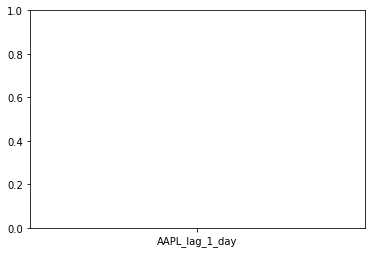

In [576]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients)

# Plot it
fig, ax = plt.subplots()
ax.scatter(feature_names, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(feature_names, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [507]:
times_scores = prices_perc.index[time_point]

## Visualizing model score variability over time
Now that you've assessed the variability of each coefficient, let's do the same for the performance (scores) of the model. Recall that the TimeSeriesSplit object will use successively-later indices for each test set. This means that you can treat the scores of your validation as a time series. You can visualize this over time in order to see how the model's performance changes over time.

An instance of the Linear regression model object is stored in model, a cross-validation object in cv, and data in X and y.

In [602]:
from sklearn.model_selection import cross_val_score

# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv)

# Convert to a Pandas Series object
scores_series = pd.DataFrame(scores, index=times_scores, columns=['score'])

In [612]:
bootstrap = partial(bootstrap_interval, percentiles=2.5)

In [629]:
from sklearn.model_selection import cross_val_score

# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv)

# Convert to a Pandas Series object
scores_series = pd.DataFrame(scores, index=times_scores, columns=['score'])

# Bootstrap a rolling confidence interval for the mean score
scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))

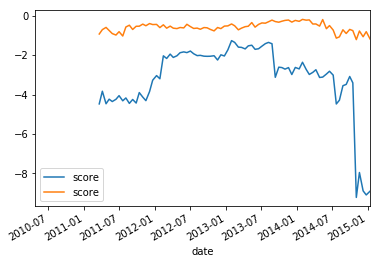

In [630]:
# Plot the results
fig, ax = plt.subplots()
scores_lo.plot(ax=ax, label="Lower confidence interval")
scores_hi.plot(ax=ax, label="Upper confidence interval")
ax.legend()
plt.show()

You plotted a rolling confidence interval for scores over time. This is useful in seeing when your model predictions are correct.

## Accounting for non-stationarity
In this exercise, you will again visualize the variations in model scores, but now for data that changes its statistics over time.

An instance of the Linear regression model object is stored in model, a cross-validation object in cv, and the data in X and y.

In [638]:
# Pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# Create an empty DataFrame to collect the stores
all_scores = pd.DataFrame(index=times_scores)

# Generate scores for each split to see how the model performs over time
for window in window_sizes:
    # Create cross-validation object using a limited lookback window
    cv = TimeSeriesSplit(n_splits=100, max_train_size=window)
    
    # Calculate scores across all CV splits and collect them in a DataFrame
    this_scores = cross_val_score(model, X, y, cv=cv, scoring='explained_variance')
    all_scores['Length {}'.format(window)] = this_scores

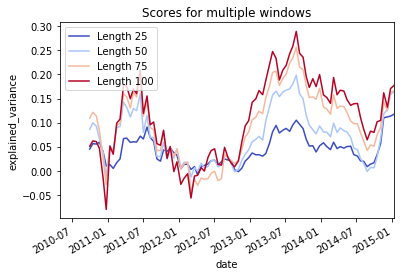

In [639]:
# Visualize the scores
ax = all_scores.rolling(10).mean().plot(cmap=plt.cm.coolwarm)
ax.set(title='Scores for multiple windows', ylabel='explained_variance')
plt.show()

notice how in some stretches of time, longer windows perform worse than shorter ones. This is because the statistics in the data have changed, and the longer window is now using outdated information.